##### Initialization

In [1]:
import numpy as np
from UAV import *
import random
from sklearn.manifold import MDS
import matplotlib.pyplot as plt   


n_robots = 3#int(input("number of robots: "))
platoon = []


# initialization of n robots
for i in range(n_robots):
    #if i==0:
    #    i_robot = Robot("op_" + str(i),0,0,0)
    #else:
    i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]

for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

#TRUE COORDINATES [REALITY: THEY ARE UNKNOWN]
S = coordinates[0:2,:]
print(S)

[[8.69708885 6.58330419 5.22656964]
 [2.16608891 9.73303605 5.7499205 ]]


##### Distance matrix definition: DM

In [2]:
#It will be fed into the MDS algorithm
DM  = d_matrix(platoon)  #distance matrix -> for sktlearn
DM2 = d_matrix2(platoon) #squared distance matrix -> for formulas

##### S* definition (estimated coordinates w/ Eigendecomposition)

In [3]:
Phi =  np.array([np.diag(S.T@S)]).T
e   = np.array([[1] for i in S[0,:]])

#DM1 = Phi@e.T - 2*S.T@S + e@Phi.T

H = np.identity(n_robots) - e@e.T/n_robots
#print(H)

ev, EV = np.linalg.eig(-1/2*H@DM2@H)

n_components = 2
LAMBDA = np.eye(n_components)
U = np.zeros((n_robots,n_components))

for i in range(n_components):
    ind  = np.argmax(ev)
    LAMBDA[i,i] = ev[ind]
    U[:,i] = EV[:,ind]
    ev[ind] = -1000

S_star11 = np.sqrt(LAMBDA)@U.T
print(S_star11)



[[-4.10031789  3.75354391  0.34677398]
 [-0.68401219 -0.89288831  1.5769005 ]]


##### S* definition (estimated coordinates w/ MDS algorithm)

In [4]:
#SKTLEARN MDS: DIMENSIONALITY REDUCTION
embedding = MDS(n_components=2,
                n_init = 50,
                max_iter = 10000,
                eps=1e-5,
                dissimilarity='precomputed') 

#ESTIMATED COORDINATES (MAY BE AFFECTED BY FLIP AND ROTATION)
S_star = embedding.fit_transform(DM).T
print(S_star)

[[ 1.12407473  0.49046815 -1.61454288]
 [-4.00038967  3.82476682  0.17562285]]


##### S' definition (to overcome rotation and flip ambiguities)

In [5]:
#FIRST DISPLACEMENT
deltaX1 = deltaY1 = 1

deltaSprime = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
deltaSprime[:,0] = [deltaX1,deltaY1]

Sprime = S + deltaSprime
print(Sprime)

[[9.69708885 6.58330419 5.22656964]
 [3.16608891 9.73303605 5.7499205 ]]


##### DM' definition (new distance matrix from S' coordinates)

In [9]:
DM_prime = DM_from_S(Sprime,verbose=1)

DM' :
 [[ 0.         52.82044953 26.66172762]
 [52.82044953  0.         17.70593814]
 [26.66172762 17.70593814  0.        ]]


In [7]:
#CHECK IF THE DIFFERENCES IN DISTANCE ARE CLOSED TO ZERO
print(DM2 - DM_prime)

[[ 0.00000000e+00  8.90632496e+00 -1.77337525e+00]
 [ 8.90632496e+00  0.00000000e+00  2.13162821e-14]
 [-1.77337525e+00  2.13162821e-14  0.00000000e+00]]


##### Estimation of the first rotation angle: $\theta_r$

In [10]:
theta_r = estimate_theta(DM2,DM_prime,S_star11,[deltaX1,deltaY1],verbose=1)

Coordinates to work with: 1-th and 2-th
After normalization: 
cos(theta):	0.579814
sin(theta):	-0.814749

Actual theta:	 -0.952296161105391
Approx theta:	 -0.9523


In [23]:
S_star2 = rotateMatrix(theta_r)@S_star11
print(S_star2)

[[-1.82010841  2.90382676 -1.08371835]
 [-3.7373366   2.5404983   1.19683831]]


Second displacement: $\left[\Delta x_2, \Delta y_2\right]$

In [19]:
deltaX2 = deltaY2 = 0.3

deltaSprime2 = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
deltaSprime2[:,0] = [deltaX2,deltaY2]

S_prime2 = S + deltaSprime2
print(S_prime2)

[[8.99708885 6.58330419 5.22656964]
 [2.46608891 9.73303605 5.7499205 ]]


Second displacement matrix: DM''

In [20]:
DM_prime2 = DM_from_S(S_prime2,verbose=1)

DM' :
 [[ 0.         58.634877   25.00036494]
 [58.634877    0.         17.70593814]
 [25.00036494 17.70593814  0.        ]]


Estimation of the second rotation angle: $\theta_{r2}$

In [21]:
theta_r2 = estimate_theta(DM2,DM_prime2,S_star2,[deltaX2,deltaY2],verbose=1)
print(theta_r2)

Coordinates to work with: 1-th and 2-th
After normalization: 
cos(theta):	-1.000000
sin(theta):	-0.000004

Actual theta:	 -3.1415888146951847
Approx theta:	 -3.1416
-3.1416


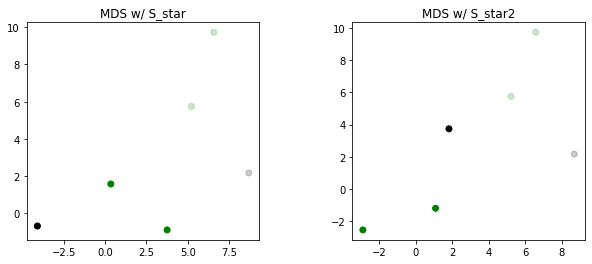

In [22]:
plot_points(S,S_star=S_star11,S_star2=S_star2)

In [ ]:
print(S-S_star2)

In [ ]:
for i in range(1,n_robots):
    #print(estimate_theta2(DM2,DM_prime,S_star,[deltaX1,deltaY1],i,verbose=0))
    break